In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import scipy.io as sc
import numpy as np
import random
import sys
import pandas

import time
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy

from keras.models import Sequential

from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM

from keras.optimizers import Adam

from keras import backend as K

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
session = tf.Session(config=config)
set_session(session)

W0309 11:57:12.338918 140624211789632 module_wrapper.py:136] From /home/sam/anaconda3/envs/build/lib/python3.7/site-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [3]:
# this function is used to transfer one column label to one hot label
def one_hot(y_):
    # Function to encode output labels from number indexes
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    y_ = y_.reshape(len(y_))
    n_values = np.max(y_) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]

In [4]:
#  Data loading
feature = sc.loadmat("S1_nolabel6.mat")
all = feature['S1_nolabel6']
print (all.shape)

np.random.shuffle(all)   # mix eeg_all

final=2800*10
all=all[0:final]
feature_all =all[:,0:64]
label=all[:,64:65]

#z-score
feature_all=preprocessing.scale(feature_all)
ft = feature_all
no_fea=feature_all.shape[-1]
label_all=one_hot(label)
lt = label_all
print (label_all.shape)

(29738, 65)
(28000, 6)


In [5]:
###CNN code
n_classes=6
epochs = 50
feature_all=feature_all# the input data of CNN
n_fea=feature_all.shape[-1]
# label_all=one_hot(label_all)
final=all.shape[0]
middle_number=final*3//4
feature_training =feature_all[0:middle_number]
feature_testing =feature_all[middle_number:final]
label_training =label_all[0:middle_number]
label_testing =label_all[middle_number:final]
label_ww=label_all[middle_number:final]  # for the confusion matrix

train_fea=[]
train_fea.append(feature_training)
train_fea_re = train_fea[0].reshape(train_fea[0].shape[0], train_fea[0].shape[1], 1).astype('float32')
train_label=[]
train_label.append(label_training)

test_fea=[]
test_fea.append(feature_testing)
test_fea_re = test_fea[0].reshape(test_fea[0].shape[0], test_fea[0].shape[1], 1).astype('float32')
test_label=[]
test_label.append(label_testing)

In [6]:
#CNN model
cnnmodel = Sequential()
cnnmodel.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(train_fea_re[0].shape[0],train_fea_re[1].shape[1])))
cnnmodel.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
cnnmodel.add(Dropout(0.5))
cnnmodel.add(MaxPooling1D(pool_size=2))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(100, activation='relu'))
cnnmodel.add(Dense(n_classes, activation='softmax'))
plot_model(cnnmodel, to_file='cnn.png')
print(cnnmodel.summary())
cnnmodel.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
cnnmodel_result = cnnmodel.fit(train_fea_re, train_label[0], batch_size=100, validation_data=(test_fea_re,test_label[0]), epochs=epochs)

W0309 11:57:12.638414 140624211789632 deprecation.py:506] From /home/sam/anaconda3/envs/build/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0309 11:57:12.647628 140624211789632 module_wrapper.py:136] From /home/sam/anaconda3/envs/build/lib/python3.7/site-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 62, 64)            256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 64)            12352     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 30, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               192100    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total para

W0309 11:57:12.734289 140624211789632 module_wrapper.py:136] From /home/sam/anaconda3/envs/build/lib/python3.7/site-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0309 11:57:12.863955 140624211789632 deprecation.py:323] From /home/sam/anaconda3/envs/build/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1423: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 21000 samples, validate on 7000 samples
Epoch 1/50
21000/21000 [==============================] - 5s 244us/step - loss: 1.2741 - acc: 0.4819 - val_loss: 1.0730 - val_acc: 0.5966
Epoch 2/50
21000/21000 [==============================] - 3s 122us/step - loss: 1.0169 - acc: 0.6110 - val_loss: 0.8841 - val_acc: 0.6780
Epoch 3/50
21000/21000 [==============================] - 3s 124us/step - loss: 0.8927 - acc: 0.6645 - val_loss: 0.7646 - val_acc: 0.7260
Epoch 4/50
21000/21000 [==============================] - 2s 119us/step - loss: 0.7953 - acc: 0.7020 - val_loss: 0.6785 - val_acc: 0.7589
Epoch 5/50
21000/21000 [==============================] - 3s 122us/step - loss: 0.7150 - acc: 0.7318 - val_loss: 0.6025 - val_acc: 0.7867
Epoch 6/50
21000/21000 [==============================] - 3s 127us/step - loss: 0.6336 - acc: 0.7634 - val_loss: 0.5034 - val_acc: 0.8320
Epoch 7/50
21000/21000 [==============================] - 3s 121us/step - loss: 0.5615 - acc: 0.7918 - val_loss: 0.4418 - v

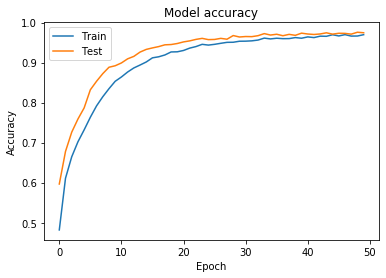

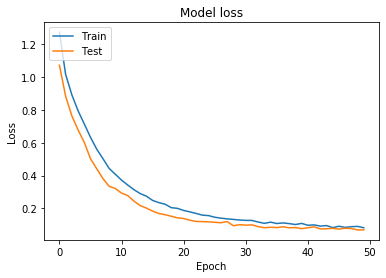

In [7]:
# Plot training & validation accuracy values
plt.plot(cnnmodel_result.history['acc'])
plt.plot(cnnmodel_result.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(cnnmodel_result.history['loss'])
plt.plot(cnnmodel_result.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [8]:
#CNN final metrics
print("<-------CNN Final Metrics------->")
print("Loss     = ",cnnmodel_result.history['val_loss'][epochs-1])
print("Accuracy = ",cnnmodel_result.history['val_acc'][epochs-1])

<-------CNN Final Metrics------->
Loss     =  0.06877558919202004
Accuracy =  0.9744285796369825


In [9]:
get_cnn_output = K.function([cnnmodel.layers[0].input],[cnnmodel.layers[5].output])
cnn_fea1 = get_cnn_output([train_fea_re])
cnn_fea2 = get_cnn_output([test_fea_re])
cnn_fea = np.hstack((cnn_fea1,cnn_fea2))
print(cnn_fea[0].shape)

(28000, 100)


In [10]:
#######RNN
n_classes=6
epochs = 250
feature_all=feature_all
no_fea=feature_all.shape[-1]
print( no_fea)
feature_all =feature_all.reshape([final,1,no_fea])
# print( tf.argmax(label_all,1))
# print (label_all.shape)
# middle_number=21000
feature_training =feature_all[0:middle_number]
feature_testing =feature_all[middle_number:final]
label_training =label_all[0:middle_number]
label_testing =label_all[middle_number:final]
# print "label_testing",label_testing
a=feature_training
b=feature_testing
print(feature_training.shape)
print(feature_testing.shape)
print(label_training.shape)
print(label_testing.shape)

train_fea=[]
train_fea.append(feature_training)
train_label=[]
train_label.append(label_training)

test_fea=[]
test_fea.append(feature_testing)
test_label=[]
test_label.append(label_testing)

64
(21000, 1, 64)
(7000, 1, 64)
(21000, 6)
(7000, 6)


In [11]:
#RNN model
rnnmodel = Sequential()
rnnmodel.add(LSTM(200, input_shape=(train_fea[0].shape[1],train_fea[0].shape[2]), dropout_U = 0.2, dropout_W = 0.2))
rnnmodel.add(Dense(n_classes,activation='softmax'))
rnnmodel.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(rnnmodel.summary())
plot_model(rnnmodel, to_file='LSTM.png')
rnnmodel_result = rnnmodel.fit(train_fea[0], train_label[0], batch_size=500, validation_data=(test_fea[0],test_label[0]), epochs=epochs)
result = rnnmodel_result

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               212000    
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1206      
Total params: 213,206
Trainable params: 213,206
Non-trainable params: 0
_________________________________________________________________
None
Train on 21000 samples, validate on 7000 samples
Epoch 1/250
21000/21000 [==============================] - 1s 54us/step - loss: 1.6544 - acc: 0.3138 - val_loss: 1.5350 - val_acc: 0.3690
Epoch 2/250
21000/21000 [==============================] - 1s 26us/step - loss: 1.4888 - acc: 0.3788 - val_loss: 1.4340 - val_acc: 0.3917
Epoch 3/250
21000/21000 [==============================] - 1s 30us/step - loss: 1.4163 - acc: 0.4073 - val_loss: 1.3706 - val_acc: 0.4241
Epoch 4/250
21000/21000 [==============================] - 1s 28

Epoch 114/250
21000/21000 [==============================] - 1s 25us/step - loss: 0.5950 - acc: 0.7823 - val_loss: 0.4234 - val_acc: 0.8689
Epoch 115/250
21000/21000 [==============================] - 1s 28us/step - loss: 0.5968 - acc: 0.7834 - val_loss: 0.4227 - val_acc: 0.8683
Epoch 116/250
21000/21000 [==============================] - 1s 27us/step - loss: 0.5916 - acc: 0.7850 - val_loss: 0.4209 - val_acc: 0.8653
Epoch 117/250
21000/21000 [==============================] - 1s 39us/step - loss: 0.5937 - acc: 0.7796 - val_loss: 0.4137 - val_acc: 0.8700
Epoch 118/250
21000/21000 [==============================] - 1s 28us/step - loss: 0.5888 - acc: 0.7843 - val_loss: 0.4167 - val_acc: 0.8673
Epoch 119/250
21000/21000 [==============================] - 1s 27us/step - loss: 0.5910 - acc: 0.7842 - val_loss: 0.4139 - val_acc: 0.8676
Epoch 120/250
21000/21000 [==============================] - 1s 27us/step - loss: 0.5822 - acc: 0.7898 - val_loss: 0.4164 - val_acc: 0.8683
Epoch 121/250
21000/

21000/21000 [==============================] - 1s 28us/step - loss: 0.4946 - acc: 0.8209 - val_loss: 0.3228 - val_acc: 0.8987
Epoch 231/250
21000/21000 [==============================] - 1s 31us/step - loss: 0.4965 - acc: 0.8196 - val_loss: 0.3241 - val_acc: 0.8964
Epoch 232/250
21000/21000 [==============================] - 1s 31us/step - loss: 0.4947 - acc: 0.8198 - val_loss: 0.3222 - val_acc: 0.8961
Epoch 233/250
21000/21000 [==============================] - 1s 27us/step - loss: 0.4927 - acc: 0.8200 - val_loss: 0.3260 - val_acc: 0.8961
Epoch 234/250
21000/21000 [==============================] - 1s 32us/step - loss: 0.4913 - acc: 0.8235 - val_loss: 0.3193 - val_acc: 0.8971
Epoch 235/250
21000/21000 [==============================] - 1s 30us/step - loss: 0.5001 - acc: 0.8182 - val_loss: 0.3172 - val_acc: 0.8960
Epoch 236/250
21000/21000 [==============================] - 1s 35us/step - loss: 0.4974 - acc: 0.8173 - val_loss: 0.3208 - val_acc: 0.8986
Epoch 237/250
21000/21000 [=======

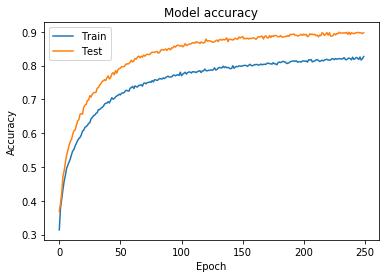

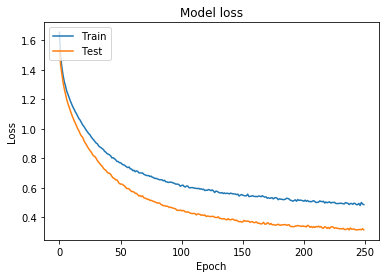

In [12]:
# Plot training & validation accuracy values
plt.plot(rnnmodel_result.history['acc'])
plt.plot(rnnmodel_result.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(rnnmodel_result.history['loss'])
plt.plot(rnnmodel_result.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
#RNN final metrics
print("<-------RNN Final Metrics------->")
print("Loss     = ",rnnmodel_result.history['val_loss'][epochs-1])
print("Accuracy = ",rnnmodel_result.history['val_acc'][epochs-1])

<-------RNN Final Metrics------->
Loss     =  0.3163649471742766
Accuracy =  0.8972857126167842


In [14]:
get_rnn_output = K.function([rnnmodel.layers[0].input],[rnnmodel.layers[0].output])
rnn_fea1 = get_rnn_output([train_fea[0]])
rnn_fea2 = get_rnn_output([test_fea[0]])
rnn_fea = np.hstack((rnn_fea1,rnn_fea2))
print(rnn_fea[0].shape)

(28000, 200)


In [15]:
#######Dense model
print(cnn_fea[0].shape,rnn_fea[0].shape)
feature_all=np.hstack((cnn_fea[0],rnn_fea[0]))
no_fea=feature_all.shape[-1]
print(no_fea)

middle_number=int(28000*3/4)
feature_training =feature_all[0:middle_number]
feature_testing =feature_all[middle_number:final]
label_training =label_all[0:middle_number]
label_testing =label_all[middle_number:final]
##AE

feature_all=feature_all

train_fea=feature_all[0:middle_number]
test_fea=feature_all[middle_number:final]
print(train_fea.shape)
print(train_label[0].shape)
print(test_fea.shape)
print(test_label[0].shape)

(28000, 100) (28000, 200)
300
(21000, 300)
(21000, 6)
(7000, 300)
(7000, 6)


In [16]:
#Dense model
epochs=10
fcc = Sequential()
fcc.add(Dense(30, activation='relu',input_shape=(train_fea.shape[1],)))
fcc.add(Dense(n_classes,activation='softmax'))
fcc.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print(fcc.summary())
fcc_result = fcc.fit(train_fea, train_label[0], batch_size=100, validation_data=(test_fea,test_label[0]), epochs=epochs)
plot_model(fcc, to_file='dense.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 30)                9030      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 186       
Total params: 9,216
Trainable params: 9,216
Non-trainable params: 0
_________________________________________________________________
None
Train on 21000 samples, validate on 7000 samples
Epoch 1/10
21000/21000 [==============================] - 2s 73us/step - loss: 0.5120 - acc: 0.8457 - val_loss: 0.1262 - val_acc: 0.9670
Epoch 2/10
21000/21000 [==============================] - 1s 52us/step - loss: 0.0427 - acc: 0.9932 - val_loss: 0.0799 - val_acc: 0.9756
Epoch 3/10
21000/21000 [==============================] - 1s 64us/step - loss: 0.0245 - acc: 0.9941 - val_loss: 0.0685 - val_acc: 0.9757
Epoch 4/10
21000/21000 [==============================] - 1s 40us/step 

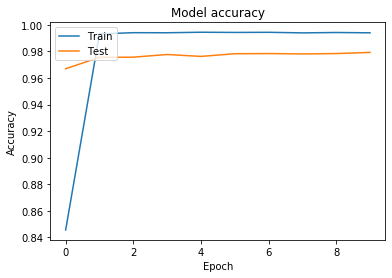

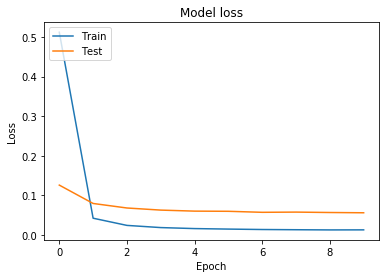

In [17]:
# Plot training & validation accuracy values
plt.plot(fcc_result.history['acc'])
plt.plot(fcc_result.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(fcc_result.history['loss'])
plt.plot(fcc_result.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
#FCC final metrics
print("<-------FCC Final Metrics------->")
print("Loss     = ",fcc_result.history['val_loss'][epochs-1])
print("Accuracy = ",fcc_result.history['val_acc'][epochs-1])

<-------FCC Final Metrics------->
Loss     =  0.056394904891827274
Accuracy =  0.9792857255254473


In [19]:
get_fcc_output = K.function([fcc.layers[0].input],[fcc.layers[0].output])
fcc_fea1 = get_fcc_output([train_fea])
fcc_fea2 = get_fcc_output([test_fea])
fcc_fea = np.hstack((fcc_fea1,fcc_fea2))
print(fcc_fea[0].shape)

(28000, 30)


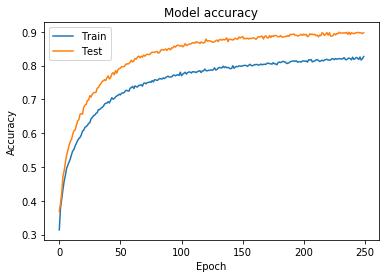

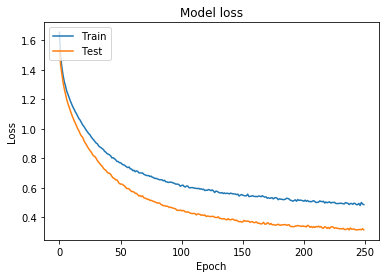

Accuracy: 97.19%


In [20]:
######## XGBoost 
train_fea = fcc_fea[0][0:middle_number]
test_fea = fcc_fea[0][middle_number:final]
#removing one-hot-encode for XGBClaasifier
train_lab = []
test_lab = []
for i in range(label_training.shape[0]):
    train_lab.append(np.argmax(label_training[i]))
for i in range(label_testing.shape[0]):
    test_lab.append(np.argmax(label_testing[i]))
#fit model on training data
xgbmodel = XGBClassifier()
xgbmodel.fit(train_fea, train_lab)
#make predictions
y_pred = xgbmodel.predict(test_fea)
#evaluate predictions
accuracy = accuracy_score(test_lab, y_pred)
# Plot training & validation accuracy values
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [21]:
print(len(ft),len(lt))
ltt = []
for i in range(lt.shape[0]):
    ltt.append(np.argmax(lt[i]))
y1 = [ft[x] for x in range(len(ft)) if ltt[x] == 1]
y2 = [ft[x] for x in range(len(ft)) if ltt[x] == 2]
y3 = [ft[x] for x in range(len(ft)) if ltt[x] == 3]
y4 = [ft[x] for x in range(len(ft)) if ltt[x] == 4]
y5 = [ft[x] for x in range(len(ft)) if ltt[x] == 5]

28000 28000


In [22]:
def get_morse(sequence):

    #getting output from models
    get_cnn_output = K.function([cnnmodel.layers[0].input],[cnnmodel.layers[5].output])
    get_rnn_output = K.function([rnnmodel.layers[0].input],[rnnmodel.layers[0].output])
    get_fcc_output = K.function([fcc.layers[0].input],[fcc.layers[0].output])

    cnn_out = []
    for i in range(len(sequence)):
        train_fea_re = sequence[i].reshape(1, sequence[i].shape[0], 1).astype('float32')
        out = get_cnn_output([train_fea_re])
        cnn_out.append(out[0][0])
    rnn_out = []
    for i in range(len(sequence)):
        train_fea_re = sequence[i].reshape([1,1,64]).astype('float32')
        out = get_rnn_output([train_fea_re])
        rnn_out.append(out[0][0])
    fcc_out = []
    for i in range(len(sequence)):
        train = []
        train.extend(cnn_out[i])
        train.extend(rnn_out[i])
        train = np.asarray(train)
        train_fea_re = train.reshape(1,300).astype('float32')
        out = get_fcc_output([train_fea_re])
        fcc_out.append(out[0][0])  
    xgb_out = ''
    for i in range(len(sequence)):
        train = np.asarray(fcc_out[i])
        train_fea_re = train.reshape(1,30).astype('float32')
        out = xgbmodel.predict(train_fea_re)
        if out == 3:
            xgb_out = xgb_out + '/'
        else:
            xgb_out = xgb_out + (str)(out[0]-1)
    return(xgb_out)

def morse_text(morse):
    code={' ':' ','a':'01','b':'1000','c':'1010','d':'100','e':'0','f':'0010',
      'g':'110','h':'0000','i':'00','j':'0111','k':'101','l':'0100','m':'11',
      'n':'10','o':'111','p':'0110','q':'1101','r':'010','s':'000','t':'1',
      'u':'001','v':'0001','w':'011','x':'1001','y':'1011','z':'1100'}
    blah=morse.split('/') 
    output=[]
    ans = ""
    for i in blah:
        output.append(i.split())
    for i in output:
        for j in i:
            for cde, value in code.items():
                if value == j:
                    ans = ans + cde 
    return(ans)

In [23]:
label_b_m = {
    '0': y1,
    '1': y2,
    '/': y3,
}
def run(ip=None):
    if not ip:
        ip = input("Enter file name => ")  
    sequence = pandas.read_csv(ip, header=None).values
    op = get_morse(sequence)
    return morse_text(op)

In [24]:
def phrase(ip=None):
    if not ip:
        ip = input()

    code={' ':' ','a':'01','b':'1000','c':'1010','d':'100','e':'0','f':'0010',
      'g':'110','h':'0000','i':'00','j':'0111','k':'101','l':'0100','m':'11',
      'n':'10','o':'111','p':'0110','q':'1101','r':'010','s':'000','t':'1',
      'u':'001','v':'0001','w':'011','x':'1001','y':'1011','z':'1100'}

    morse_ = ''
    for i in ip:
        morse_ += code[i] + '/'
    morse_ = morse_[:-1]
        #generating sequence
    sequence = []

    for i in morse_:
        sequence.append(random.choice(label_b_m[i]))
    op = get_morse(sequence)
    return morse_text(op)

In [25]:
run('h.csv')

'h'

In [26]:
phrase('reviewtwo')

'revieutwo'